# Chest X Ray Images classification with DenseNet121 and explain with GradCam

In [414]:
import os
import numpy as np 
import pandas as pd 
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model, load_model

import cv2
import glob

import warnings
warnings.filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Data loading from path

The dataset used was downloading form kaggle, here is [the link](https://www.kaggle.com/datasets/francismon/curated-covid19-chest-xray-dataset)

In [416]:
# for dirname, _, filenames in os.walk('/Users/lamine/tensorflow-test/dataset/'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [291]:
image_dir = '/Users/lamine/tensorflow-test/dataset'
dir_train = f'{image_dir}/train'
dir_valid = f'{image_dir}/validation'

# Functions 

Can be used as ```util.py``` file. 

The gradcam function is adated fron [here](https://gist.github.com/RaphaelMeudec/e9a805fa82880876f8d89766f0690b54)

In [411]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Model
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity
from keras.utils import to_categorical   
import os

random.seed(a=None, version=2)

set_verbosity(INFO)


def get_mean_std_per_batch(image_dir, H=299, W=299):
    sample_data = []
    for img in train_generator.filepaths:
        raw_image = cv2.imread(img)
        sample_data.append(
            np.array(image.load_img(img, target_size=(H, W))))

    mean = np.mean(sample_data, axis=(0, 1, 2, 3))
    std = np.std(sample_data, axis=(0, 1, 2, 3), ddof=1)
    return mean, std


def load_image(img, image_dir, preprocess=True, H=299, W=299):
    """Load and preprocess image."""
    mean, std = get_mean_std_per_batch(image_dir, H=H, W=W)
    img_path = os.path.join(image_dir, img)
    x = image.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x

def grad_cam(model, img, layer_name):
    
    grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.array([img]))
        pred_class = tf.argmax(predictions[0])
        loss = predictions[:, pred_class]
    
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]
    
    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads
    
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    
    cam = np.ones(output.shape[0: 2], dtype = np.float32)
    
    for i, w in enumerate(weights):
        cam += w * output[:, :, i]
    
    cam = cv2.resize(cam.numpy(), (299, 299))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())
    
    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    
    output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 1, 0)
    
    return output_image


def compute_gradcam(model, img, image_dir, labels, selected_labels,
                    layer_name='bn'):
    img_path = os.path.join(image_dir, img)
    image = load_image(img, image_dir)
    predictions = model.predict(image)
    img = cv2.imread(img_path)
    print("Loading original image")
    plt.figure(figsize=(15, 10))
    plt.subplot(151)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(img, cmap='gray')

    j = 1
    for i in range(len(labels)):
        if labels[i] in selected_labels:
            print(f"Generating gradcam for class {labels[i]}")
            gradcam = grad_cam(model, img, layer_name)
            plt.subplot(151 + j)
            plt.title(f"{labels[i]}: p={predictions[0][i]:.3f}")
            plt.axis('off')
            plt.imshow(img, cmap='gray')
            plt.imshow(gradcam, cmap='jet', alpha=min(0.5, predictions[0][i]))
            j += 1


def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            categorical_labels = to_categorical(generator.labels, num_classes=3)
            gt = categorical_labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

# Data visualization

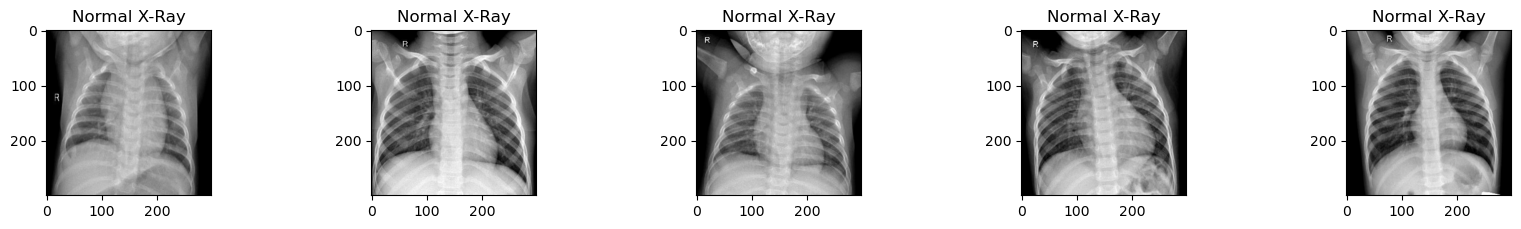

In [294]:
plt.figure(figsize=(20 , 15))
for i in np.arange(1,6):
    plt.subplot(5, 5, i)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    # Normal
    dir_img = f'{dir_train}/0_Normal/Normal ({i}).jpg'
    img = cv2.imread(dir_img)
    plt.imshow(img) 
    plt.title('Normal X-Ray')

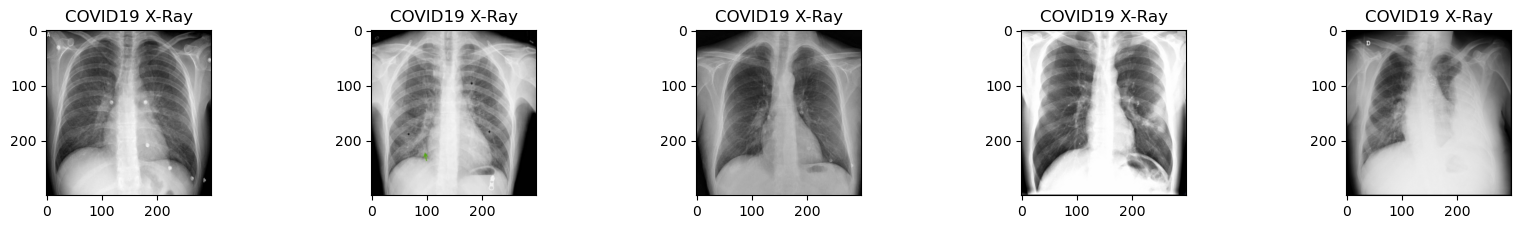

In [295]:
plt.figure(figsize=(20 , 15))
for i in np.arange(1,6):
    plt.subplot(5, 5, i)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    # COVID-19
    dir_img = f'{dir_train}/1_Covid19/COVID-19 ({i}).jpg'
    img = cv2.imread(dir_img)
    plt.imshow(img) 
    plt.title('COVID19 X-Ray')

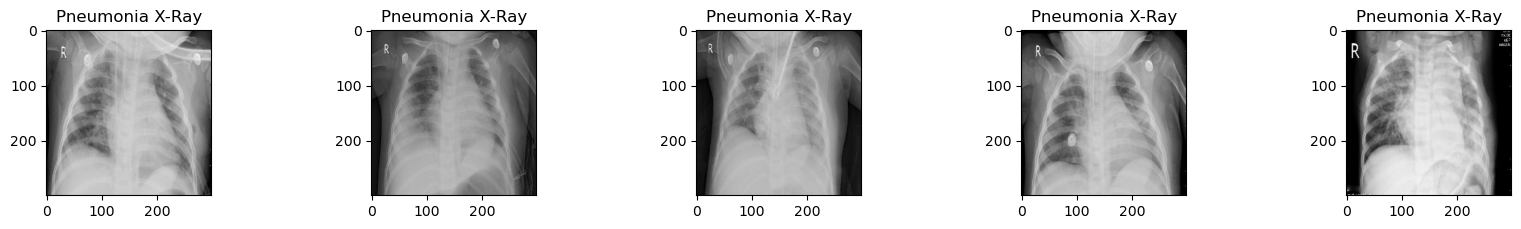

In [296]:
plt.figure(figsize=(20 , 15))
for i in np.arange(1,6):
    plt.subplot(5, 5, i)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    # Pneumonia-Bacterial
    dir_img = f'{dir_train}/2_Pneumonia/Pneumonia-Bacterial ({i}).jpg'
    img = cv2.imread(dir_img)
    plt.imshow(img) 
    plt.title('Pneumonia X-Ray')

### Raw single image

The dimensions of the image are 299 pixels width and 299 pixels height, one single color channel
The maximum pixel value is 253.000 and the minimum is 0.000
The mean value of the pixels is 113.239 and the standard deviation is 67.740


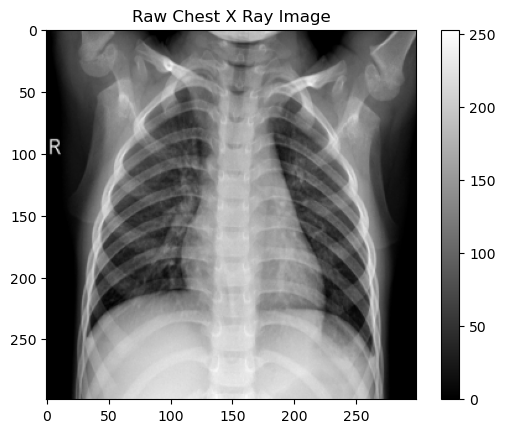

In [289]:
# Get the first image that was listed in the train_df dataframe
sample_img =  f'{dir_train}/0_Normal/Normal ({775}).jpg'
raw_image = plt.imread(sample_img)
plt.imshow(raw_image, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, one single color channel")
print(f"The maximum pixel value is {raw_image.max():.3f} and the minimum is {raw_image.min():.3f}")
print(f"The mean value of the pixels is {raw_image.mean():.3f} and the standard deviation is {raw_image.std():.3f}")

Text(0, 0.5, '# Pixels in Image')

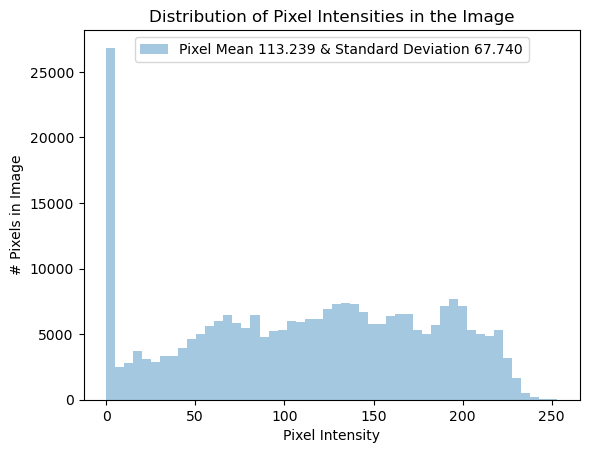

In [290]:
# Plot a histogram of the distribution of the pixels
sns.distplot(raw_image.ravel(), 
             label=f'Pixel Mean {np.mean(raw_image):.3f} & Standard Deviation {np.std(raw_image):.3f}', kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

In [16]:
# Get the image shape and print it out
height, width, channels = raw_image.shape
print(f"The image object has the following dimensions: height: {height}, width: {width}, channels: {channels}")

The image object has the following dimensions: height: 299, width: 299, channels: 3


# Image preprocessing and augmentation with Keras

In [5]:
CLASSES = ['0_Normal', '1_Covid19', '2_Pneumonia']

In [396]:
def get_generator(image_dir, subset=' ', classes = CLASSES, shuffle=True, batch_size=32, seed=1, target_w = 299, target_h = 299):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      image_dir (str): directory where image files are held.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
      classes (str): list of labels images
    
    Returns:
        train_generator or validation_generator (DataFrameIterator): iterator over training set
    """     
    print("getting generators from path...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True,
        validation_split=0.30)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_directory(
            directory=image_dir,
            class_mode='categorical',
            classes=CLASSES,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            subset= subset,
            target_size=(target_w,target_h))
    
    return generator

In [308]:
train_generator = get_generator(dir_train, subset='training')
validation_generator = get_generator(dir_train, subset='validation')
test_generator = get_train_generator(dir_valid, subset='validation')

getting generators from path...
Found 5159 images belonging to 3 classes.
getting generators from path...
Found 2208 images belonging to 3 classes.
getting train and validation generator...
Found 551 images belonging to 3 classes.


In [399]:
print(f"There are {train_generator.samples} images belonging to the {len(CLASSES)} classes for model training")
print(f"There are {validation_generator.samples} images belonging to the {len(CLASSES)} classes for model validation")
print(f"There are {test_generator.samples} images belonging to the {len(CLASSES)} classes for model testing")

There are 5159 images belonging to the 3 classes for model training
There are 2208 images belonging to the 3 classes for model validation
There are 551 images belonging to the 3 classes for model testing


In [397]:
def describeData(x, y):
    """
    x : is a generator
    y : labels generator
    """
    print('Total number of images: {}'.format(x.samples))
    print('Number of Normal images: {}'.format(np.sum(y==0)))
    print('Number of Covid images: {}'.format(np.sum(y==1)))
    print('Number of Pneumonia images: {}'.format(np.sum(y==2)))
    print('Pourcentage of positive images: {:.2f}%'.format(100*np.mean(y)))
    print('Image shape Width, height, channels: {}'.format(x.image_shape))

In [328]:
describeData(train_generator, train_generator.labels)

Total number of images: 5159
Number of Normal images: 1832
Number of Covid images: 718
Number of Pneumonia images: 2609
Pourcentage of positive images: 115.06%
Image shape Width, height, channels: (299, 299, 3)


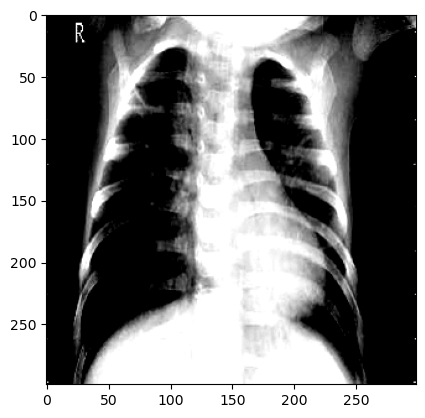

In [310]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0]);

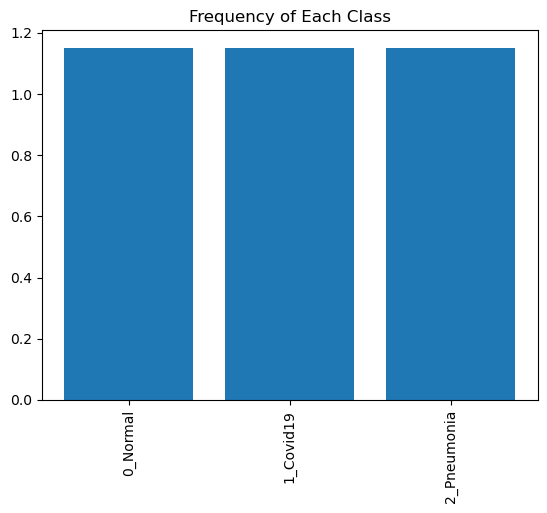

In [311]:
plt.xticks(rotation=90)
plt.bar(x=CLASSES, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

# Model

In [345]:
EPOCHS = 10
NB_CLASSES = 3  
input_shape = [299, 299, 3]

In [347]:
# create the base pre-trained model
base_model = DenseNet121(input_shape=input_shape,weights='imagenet',include_top=False)
for layers in base_model.layers:
    layers.trainable=False


In [348]:
x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

prediction = Dense(NB_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=prediction)

In [349]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

## Model train

In [350]:
history = model.fit_generator(train_generator, 
                              validation_data=validation_generator,
                              steps_per_epoch=100, 
                              validation_steps=25, 
                              epochs = EPOCHS)


Epoch 1/10


2024-02-27 10:20:36.453024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 0.5844 - accuracy: 0.7750

2024-02-27 10:20:50.275272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 21s 151ms/step - loss: 0.5844 - accuracy: 0.7750 - val_loss: 0.2799 - val_accuracy: 0.9237
Epoch 2/10
100/100 [==============================] - 12s 119ms/step - loss: 0.2397 - accuracy: 0.9287 - val_loss: 0.2161 - val_accuracy: 0.9312
Epoch 3/10
100/100 [==============================] - 12s 124ms/step - loss: 0.1938 - accuracy: 0.9366 - val_loss: 0.1695 - val_accuracy: 0.9513
Epoch 4/10
100/100 [==============================] - 13s 125ms/step - loss: 0.1739 - accuracy: 0.9431 - val_loss: 0.1651 - val_accuracy: 0.9500
Epoch 5/10
100/100 [==============================] - 13s 125ms/step - loss: 0.1697 - accuracy: 0.9438 - val_loss: 0.1370 - val_accuracy: 0.9513
Epoch 6/10
100/100 [==============================] - 14s 138ms/step - loss: 0.1532 - accuracy: 0.9499 - val_loss: 0.1285 - val_accuracy: 0.9525
Epoch 7/10
100/100 [==============================] - 14s 135ms/step - loss: 0.1412 - accuracy: 0.9559 - val_loss: 0.1229 - val_accuracy: 0.9

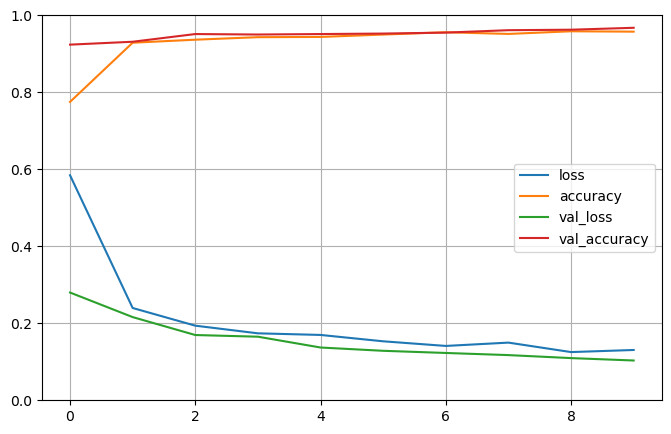

In [351]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

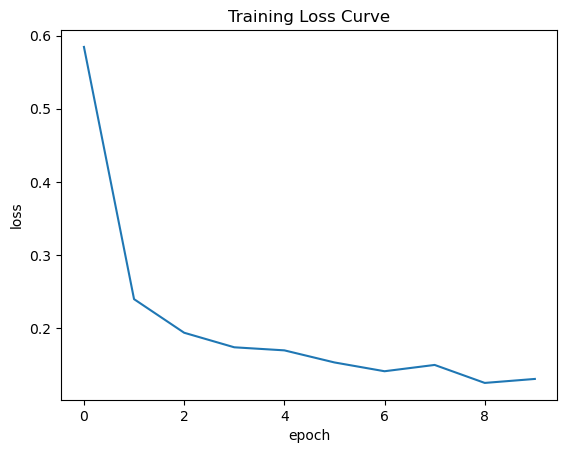

In [352]:
plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

## Model evaluate

In [366]:
#evalute the model
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

18/18 [==============================] - 2s 110ms/step - loss: 0.1814 - accuracy: 0.9292
Test accuracy: 0.9292196035385132


In [367]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

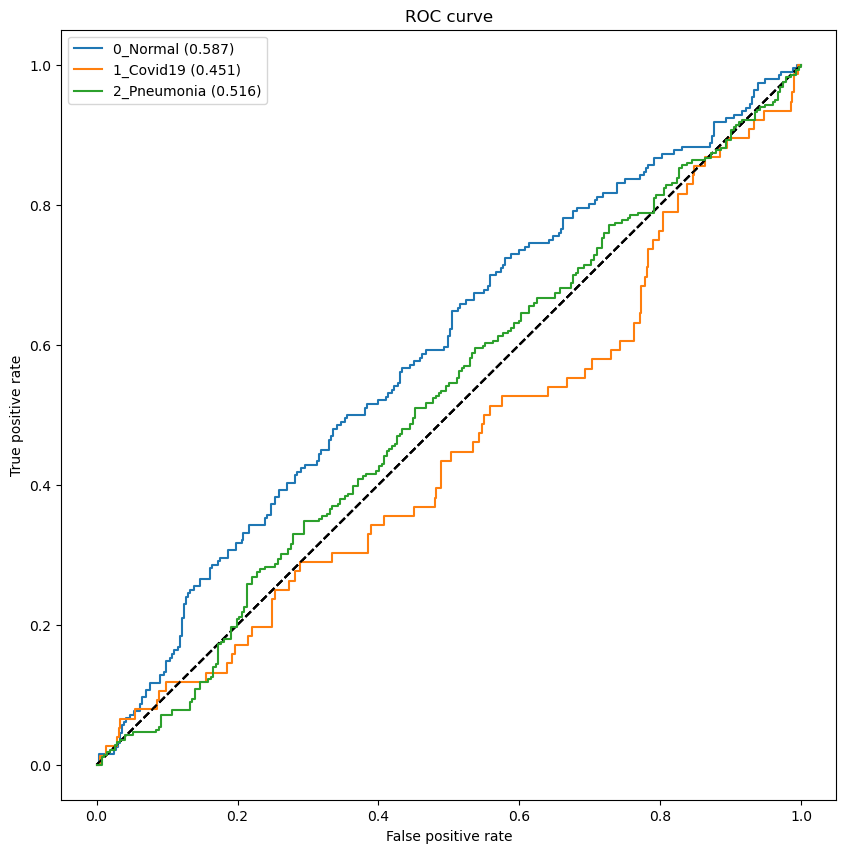

In [368]:
auc_rocs = get_roc_curve(CLASSES, predicted_vals, test_generator)

## Label Prediction

In [378]:
y_pred = model.predict(test_generator)
y_pred = np.around(y_pred, decimals=0)
y_test = validation_generator.classes

18/18 [==============================] - 2s 109ms/step


In [379]:
train_generator.class_indices

{'0_Normal': 0, '1_Covid19': 1, '2_Pneumonia': 2}

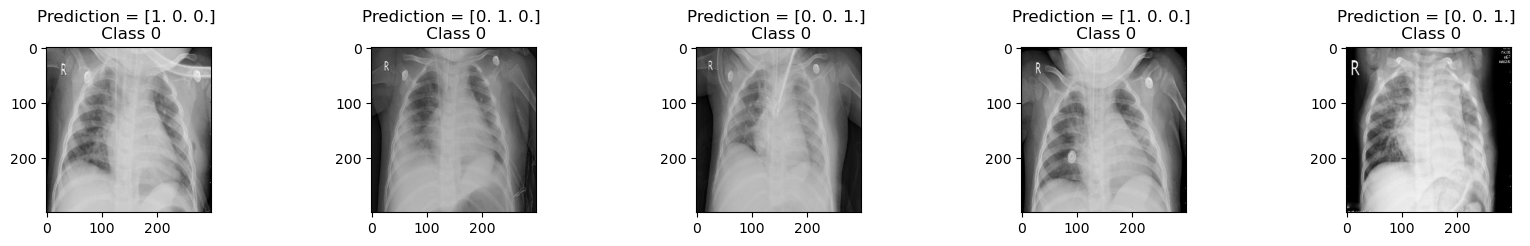

In [380]:
plt.figure(figsize=(20 , 15))
for i in np.arange(1,6):
    plt.subplot(5, 5, i)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    # Pneumonia-Bacterial
    dir_img = f'{dir_train}/2_Pneumonia/Pneumonia-Bacterial ({i}).jpg'
    img = cv2.imread(dir_img)
    plt.imshow(img) 
    plt.title("Prediction = {} \n Class {}".format(y_pred[i], y_test[i]))

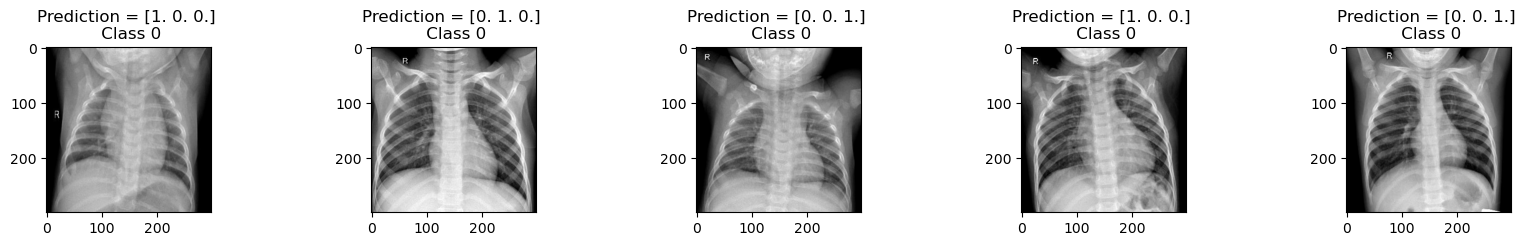

In [381]:
plt.figure(figsize=(20 , 15))
for i in np.arange(1,6):
    plt.subplot(5, 5, i)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    # Pneumonia-Bacterial
    dir_img = f'{dir_train}/0_Normal/Normal ({i}).jpg'
    img = cv2.imread(dir_img)
    plt.imshow(img) 
    plt.title("Prediction = {} \n Class {}".format(y_pred[i], y_test[i]))

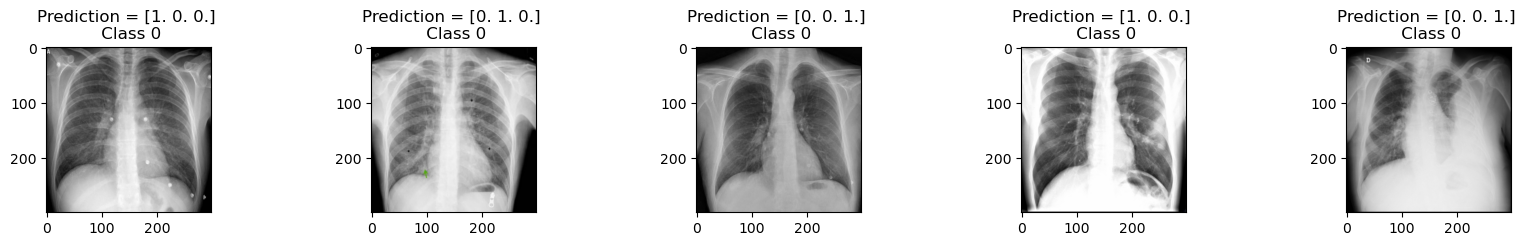

In [382]:
plt.figure(figsize=(20 , 15))
for i in np.arange(1,6):
    plt.subplot(5, 5, i)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    # Pneumonia-Bacterial
    dir_img = f'{dir_train}/1_Covid19/COVID-19 ({i}).jpg'
    img = cv2.imread(dir_img)
    plt.imshow(img) 
    plt.title("Prediction = {} \n Class {}".format(y_pred[i], y_test[i]))

# Model explain with GradCam 

## Normal Label

In [370]:
labels_to_show = np.take(CLASSES, np.argsort(auc_rocs)[::-1])[:4]
labels_to_show

array(['0_Normal', '2_Pneumonia', '1_Covid19'], dtype='<U11')

2024-02-27 10:27:58.405487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step
Loading original image
Generating gradcam for class 0_Normal
Generating gradcam for class 1_Covid19
Generating gradcam for class 2_Pneumonia


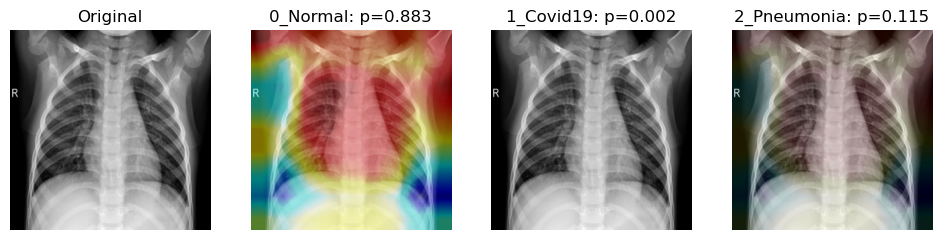

In [371]:
dir_img = '/Users/lamine/tensorflow-test/dataset/train/0_Normal' 
compute_gradcam(model, 'Normal (775).jpg', dir_img, CLASSES, labels_to_show, layer_name='bn')

1/1 [==============================] - 0s 392ms/step
Loading original image
Generating gradcam for class 0_Normal
Generating gradcam for class 1_Covid19
Generating gradcam for class 2_Pneumonia


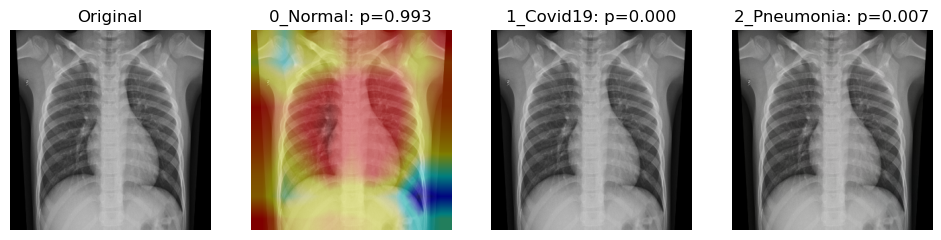

In [372]:
dir_img = '/Users/lamine/tensorflow-test/dataset/train/0_Normal' 
compute_gradcam(model, 'Normal (2551).jpg', dir_img, CLASSES, labels_to_show, layer_name='bn')

## Covid19 label

1/1 [==============================] - 0s 297ms/step
Loading original image
Generating gradcam for class 0_Normal
Generating gradcam for class 1_Covid19
Generating gradcam for class 2_Pneumonia


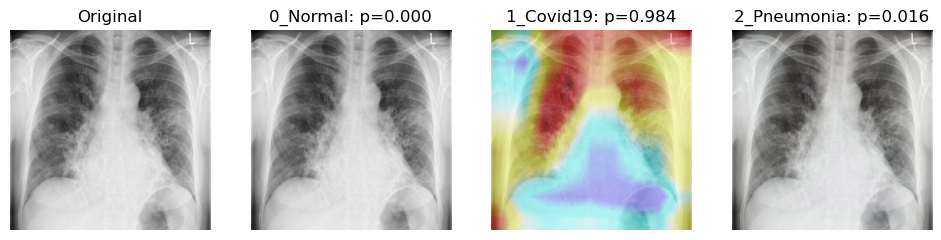

In [373]:
dir_covid = '/Users/lamine/tensorflow-test/dataset/train/1_Covid19'
compute_gradcam(model, 'COVID-19 (293).jpg', dir_covid, CLASSES, labels_to_show, layer_name='bn')

1/1 [==============================] - 0s 32ms/step
Loading original image
Generating gradcam for class 0_Normal
Generating gradcam for class 1_Covid19
Generating gradcam for class 2_Pneumonia


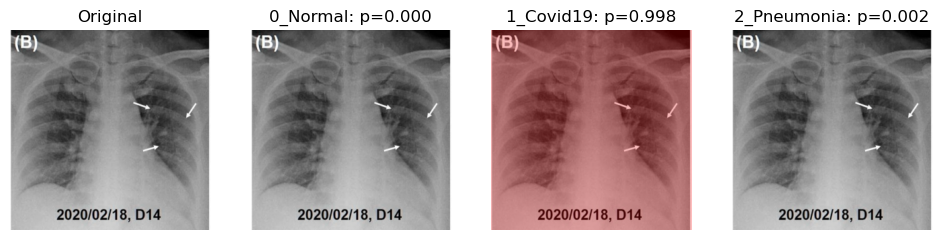

In [374]:
dir_covid = '/Users/lamine/tensorflow-test/dataset/train/1_Covid19'
compute_gradcam(model, 'COVID-19 (1020).jpg', dir_covid, CLASSES, labels_to_show, layer_name='bn')

## Pneumonia label

1/1 [==============================] - 0s 32ms/step
Loading original image
Generating gradcam for class 0_Normal
Generating gradcam for class 1_Covid19
Generating gradcam for class 2_Pneumonia


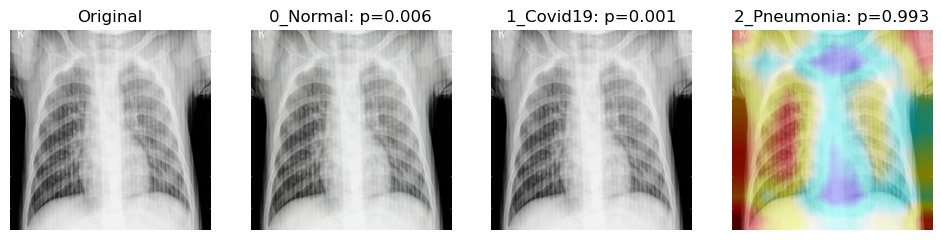

In [375]:
dir_img = '/Users/lamine/tensorflow-test/dataset/train/2_Pneumonia'
compute_gradcam(model, 'Pneumonia-Viral (291).jpg', dir_img, CLASSES, labels_to_show, layer_name='bn')

1/1 [==============================] - 0s 32ms/step
Loading original image
Generating gradcam for class 0_Normal
Generating gradcam for class 1_Covid19
Generating gradcam for class 2_Pneumonia


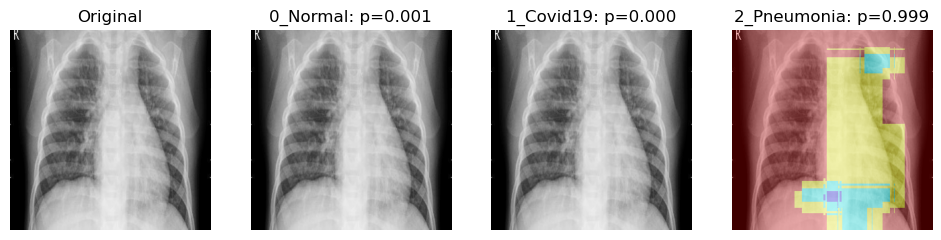

In [376]:
dir_img = '/Users/lamine/tensorflow-test/dataset/train/2_Pneumonia'
compute_gradcam(model, 'Pneumonia-Viral (286).jpg', dir_img, CLASSES, labels_to_show, layer_name='bn')

1/1 [==============================] - 0s 32ms/step
Loading original image
Generating gradcam for class 0_Normal
Generating gradcam for class 1_Covid19
Generating gradcam for class 2_Pneumonia


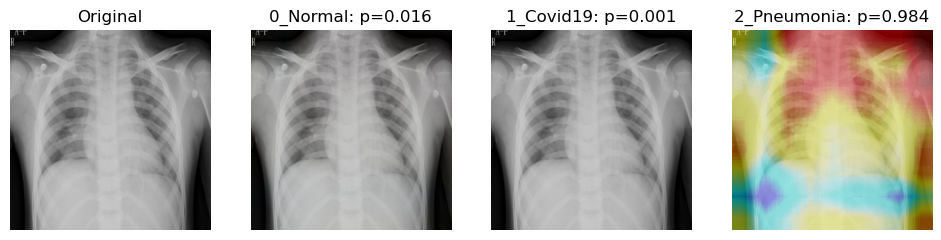

In [377]:
dir_img = '/Users/lamine/tensorflow-test/dataset/train/2_Pneumonia'
compute_gradcam(model, 'Pneumonia-Bacterial (2900).jpg', dir_img, CLASSES, labels_to_show, layer_name='bn')